In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import wandb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [18]:
class Perceptron:
    def __init__(self, n_feature = 1, epoch = 2000, lr = 0.01, tol = None, wandb=True):
        self.n_feature = n_feature
        self.epoch = epoch
        self.lr = lr
        self.tol = tol
        self.wandb = wandb
        self.W = (np.random.rand(n_feature + 1) * 0.5).reshape(-1,1)
        self.loss = []
        self.best_loss = np.inf
        self.patience = 100
        self.X_train_bar = []

    # def _loss(self, y, y_pred):
    #     return -y_pred * y if y_pred * y <0 else 0
    
    # def _gradient(self, x_bar, y, y_pred):
    #     return -y * x_bar if y_pred * y <0 else 0

    def _preprocess_data(self,X):
        m, n = X.shape
        X_ = np.empty([m, n+1])
        X_[:, 0] = 1
        X_[:, 1:] = X
        return X_
    
    def _loss(self, y, y_pred):
        loss = y_pred * y
        loss_all = -loss[loss < 0]
        return np.sum(loss_all)

    def _gradient(self, inputs, outputs, groundtruths):
        batch_size = inputs.shape[0]
        grads = np.zeros_like(inputs)
    
        for i in range(batch_size):
            input = inputs[i]
            output = outputs[i]
            groundtruth = groundtruths[i]
            grad = - groundtruth * input.reshape(-1, 1) if output * groundtruth < 0 else np.zeros_like(input)
            grads[i] = grad.reshape(-1)
    
        # 求平均梯度
        avg_grad = np.mean(grads, axis=0).reshape(-1, 1)
        return avg_grad
    
    def fit(self, X, y):
        break_out = False
        epoch_no_improve = 0
        X = self._preprocess_data(X)
        for epoch in range(self.epoch):
            y_pred = self._predict(X)
            loss = self._loss(y, y_pred)
            self.loss.append(loss)
            # if self.wandb:
            # wandb.log({"loss": loss, "epoch": epoch})
            if loss < self.best_loss - self.tol:
                self.best_loss = loss
                epoch_no_improve = 0
            elif np.abs(loss - self.best_loss) < self.tol:
                epoch_no_improve += 1
                if epoch_no_improve >= self.patience:
                    print(f"Early stopping triggered at {epoch} due to the no improvement in loss")
                    break_out = True
                    break
                else:
                    epoch_no_improve = 0
            # i = np.random.randint(0, len(X))
            # grad = self._gradient(np.expand_dims(X[i], axis=0), np.expand_dims(y_pred[i], axis=0), np.expand_dims(y[i], axis=0))
            grad = self._gradient(X, y_pred, y)
            self.W -= self.lr * grad        
            if break_out:
                break_out = False
                break

    def _bgd_update(self, X, y): #lr=1e-6
        pred = X @ self.W 
        grad = self._gradient(X, y, pred)
        self.W -= self.lr * grad  # 批量梯度下降更新

    def _predict(self, X):
        return np.sign(X @ self.W)

    def evaluate(self, X_test, y_test):
        TP,FP,FN,TN = 0,0,0,0
        X_test = self._preprocess_data(X_test)
        for i in range(len(X_test)):
            y = np.sign(self._predict(X_test[i]))
            if y == 1 and y_test[i] == 1:
                TP += 1
            elif y == 1 and y_test[i] == -1:
                FP += 1
            elif y == -1 and y_test[i] == 1:
                FN += 1
            elif y == -1 and y_test[i] == -1:
                TN += 1
        # print(TP, FP, FN, TN)
        accuracy = (TP + TN) / (TP + FP + FN + TN)
        recall = TP / (TP + FN)
        precision = TP / (TP + FP)
        F1 = 2 * precision * recall / (precision + recall)
    
        print(f"evaluation results: \naccuracy: {accuracy}, \nrecall: {recall}, \nprecision: {precision}, \nF1: {F1}")

从wine.data中删除一类样本，并将保留后的两类样本wine_data_filtered作为新的数据集，并以（0.7，0.3）的比例将wine_data_filtered分为training set和test set

In [19]:
# wandb.login()
# wandb.init(project="perceptron")

file_name = 'wine.data'

# 读取数据集
column_names = ['class_label'] + [f'feature_{i}' for i in range(13)]  
wine_data = pd.read_csv(file_name, header=None, names=column_names)

# 显示原始数据集的类别分布
print("Original dataset class distribution:")
print(wine_data['class_label'].value_counts())

# 删除 class_label = 3 的所有行
wine_data_filtered = wine_data[wine_data['class_label'] != 3]

# 显示新数据集的类别分布
print("\nNew dataset class distribution:")
print(wine_data_filtered['class_label'].value_counts())

# 检查新数据集的形状
print("\nOriginal dataset shape:", wine_data.shape)
print("New dataset shape:", wine_data_filtered.shape)

# 将数据分为特征和标签
X = wine_data_filtered.drop('class_label', axis=1).values
y = wine_data_filtered['class_label'].values

# 划分训练集和测试集，这里我们按照70%训练集，30%测试集的比例来划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_train[y_train == 2] = -1
y_test[y_test == 2] = -1
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# 打印结果以确认划分
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Original dataset class distribution:
class_label
2    71
1    59
3    48
Name: count, dtype: int64

New dataset class distribution:
class_label
2    71
1    59
Name: count, dtype: int64

Original dataset shape: (178, 14)
New dataset shape: (130, 14)
Training set shape: (91, 13)
Test set shape: (39, 13)


Learned weights are [[ -115.30524229]
 [ -827.36292911]
 [  340.71509305]
 [ -137.53923375]
 [-3305.78657888]
 [ -961.70950472]
 [ -154.2379038 ]
 [  128.27265071]
 [  -60.60530627]
 [   34.16964268]
 [  381.57429824]
 [ -153.12082353]
 [  -57.65606894]
 [  167.40509265]]
evaluation results: 
accuracy: 0.7948717948717948, 
recall: 0.6, 
precision: 1.0, 
F1: 0.7499999999999999


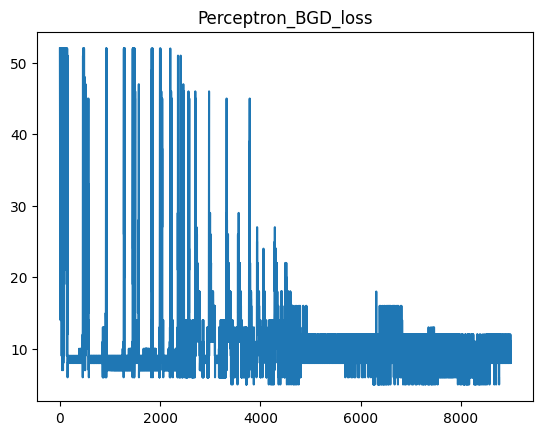

In [20]:
model = Perceptron(n_feature = X_train.shape[1], epoch = 9000, lr = 1, tol = 1e-3)
model.fit(X_train,y_train)
print(f"Learned weights are {model.W}")
model.evaluate(X_test,y_test)
plt.plot(model.loss)
plt.title('Perceptron_BGD_loss')
wandb.finish()